In [1]:
import numpy as np
import matplotlib.pyplot as plt

import preprocessing as prep
import visualization as vis
from filtering import LPF


In [2]:
DATA_DIR = "titan-hf-2"

SENSORS = {"b_load_1": "LC1 Axial Load",
           "thermo_2": "TC2 Combustion Chamber Temperature",
           "pres_1": "PT1 Combustion Chamber Pressure",
           "pres_2": "PT2 Feedline Pressure",
           "pres_3": "PT3 Injector Pressure",
           "pres_4": "PT4 Ox-Tank Pressure"}

DRIVERS = {0: {"name": "Feedline", "false": "Close", "true": "Open"},
           1: {"name": "Ox Vent", "false": "Close", "true": "Open"},
           2: {"name": "Ground Vent", "false": "Open", "true": "Close"},
           3: {"name": "Pressurization System", "false": "Close", "true": "Open"},
           5: {"name": "Ignition", "false": "Shutoff", "true": "Ignite"}}

In [3]:
prep.process_events(DATA_DIR, DRIVERS)
prep.process_data(DATA_DIR, SENSORS)

In [4]:
events = prep.import_events(DATA_DIR)
labels, data = prep.import_data(DATA_DIR, events)
times = data[:, 0]

print(f"HF2 Data Summary \n----------------- \n Sensors: {len(labels) - 1} \n" f" Samples: {len(times)} \n Events:  {len(events)}")

HF2 Data Summary 
----------------- 
 Sensors: 6 
 Samples: 1922544 
 Events:  35


In [5]:
ep = vis.EventPlotter(data, events, dpi=100)
lpf = LPF(fs=300, length=101, cutoff=10, window="blackman")

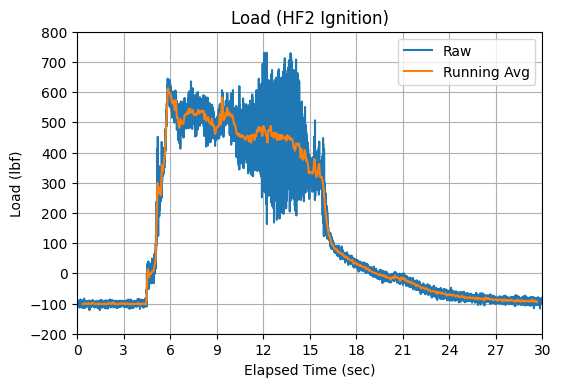

In [6]:
ep.plot(sensor_id=1, event_id=31, duration=30, filter=lpf,
        title="Load (HF2 Ignition)", ylabel="Load (lbf)",
        num_xticks=11, dif_yticks=100)

In [12]:
time_start = float(events[31]["secs"])
time_end = time_start + 27
sample_start = vis.nearest_sample(data, time_start)
sample_end = vis.nearest_sample(data, time_end)

times_event = [t - time_start for t in times[sample_start : sample_end]]
data_event = data[sample_start : sample_end, 1]

offset = np.mean(data_event[0:1000])

impulse_total = 0
for sample in data_event[int(300*4.48):]:
    impulse_total += (sample - offset) / 300

impulse_main = 0
for sample in data_event[int(300*4.48):int(300*15.8)]:
    impulse_main += (sample - offset) / 300

peak_thrust = max(data_event) - offset
peak_sustained_thrust = np.mean(data_event[int(300*5.83) : int(300*5.88)]) - offset
avg_thrust = impulse_main / ((int(300*15.8) - int(300*4.48)) / 300)

print(f"Peak Thrust:\t\t   {peak_thrust:.2f}  lbf")
print(f"Peak Sustained Thrust:\t   {peak_sustained_thrust:.2f}  lbf")
print(f"Avg Thrust @ Supersonic:   {avg_thrust:.2f}  lbf")
print(f"Impulse @ Supersonic:\t  {impulse_main:.2f}  lb-sec")
print(f"Total Impulse:\t\t  {impulse_total:.2f}  lb-sec")

Peak Thrust:		   830.86  lbf
Peak Sustained Thrust:	   713.60  lbf
Avg Thrust @ Supersonic:   537.85  lbf
Impulse @ Supersonic:	  6088.50  lb-sec
Total Impulse:		  7032.50  lb-sec


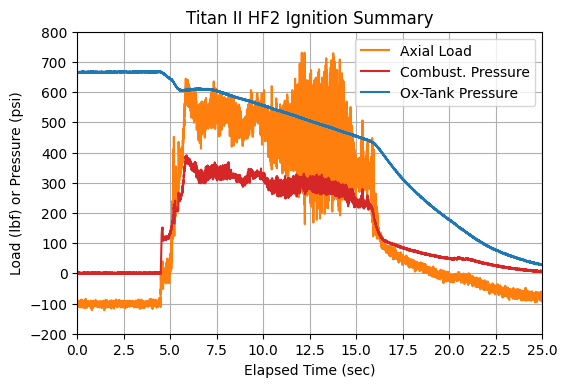

In [8]:
ep.plot(sensor_id=1, event_id=31, duration=25, filter=None,
        title="Titan II HF2 Ignition Summary", ylabel="Load (lbf) or Pressure (psi)",
        legend="Axial Load", num_xticks=11, dif_yticks=100, color="tab:orange")
ep.add_curve(sensor_id=3, event_id=31, duration=25, legend="Combust. Pressure", 
             color="tab:red")
ep.add_curve(sensor_id=6, event_id=31, duration=25, legend="Ox-Tank Pressure", color="tab:blue")
plt.show()